In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('../data/prcp_monthly.csv')
data['month'] = pd.to_datetime(data['month'])
data.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')
data.head()

,index,month,prcp
2001-01-31,0,2001-01-01,101.4
2001-02-28,1,2001-02-01,98.2
2001-03-31,2,2001-03-01,201.2
2001-04-30,3,2001-04-01,141.2
2001-05-31,4,2001-05-01,33.3


Train test split:

In [2]:
train = data[data['month'].dt.year <= 2015]
test = data[data['month'].dt.year > 2015]

## 1. Simple Exponential Smoothing (SES):

- Suitable for forecasting data with no clear trend or seasonal pattern

In [36]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(train['prcp']).fit(smoothing_level=0.2)
ses.summary()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


Dep. Variable:,prcp,No. Observations:,180
Model:,SimpleExpSmoothing,SSE,1458162.032
Optimized:,False,AIC,1623.951
Trend:,None,BIC,1630.337
Seasonal:,None,AICC,1624.180
Seasonal Periods:,None,Date:,"Thu, 06 Mar 2025"
Box-Cox:,False,Time:,10:12:18
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2000000,alpha,False
initial_level,101.40000,l.0,False


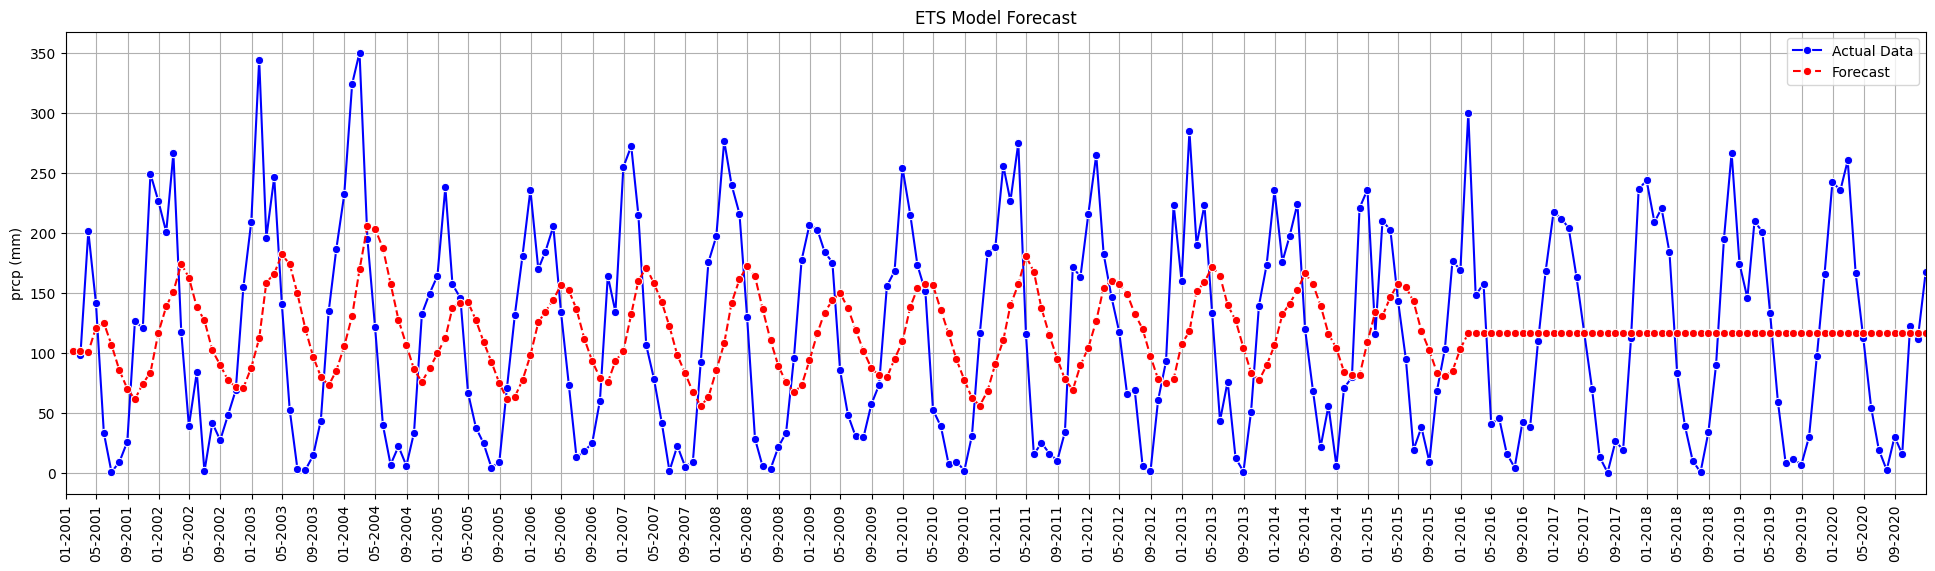

In [37]:
import matplotlib.dates as mdates
import seaborn as sns

forecast = ses.forecast(steps=len(test))
fitted_values = pd.concat([ses.fittedvalues, forecast])
fitted_values.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')

plt.figure(figsize=(24, 6))
sns.lineplot(data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(fitted_values, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("ETS Model Forecast")
plt.legend()
# plt.savefig('../forecast/simple_ets_model.png')
plt.show()

- Output is bad.

## 2. Holt's linear trend:

In [38]:
from statsmodels.tsa.api import Holt

holt = Holt(train['prcp'], damped_trend=True).fit(smoothing_level=0.2)
holt.summary()

Dep. Variable:,prcp,No. Observations:,180
Model:,Holt,SSE,1477220.092
Optimized:,True,AIC,1632.289
Trend:,Additive,BIC,1648.254
Seasonal:,None,AICC,1632.940
Seasonal Periods:,None,Date:,"Thu, 06 Mar 2025"
Box-Cox:,False,Time:,10:12:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2000000,alpha,False
smoothing_trend,0.0050000,beta,True


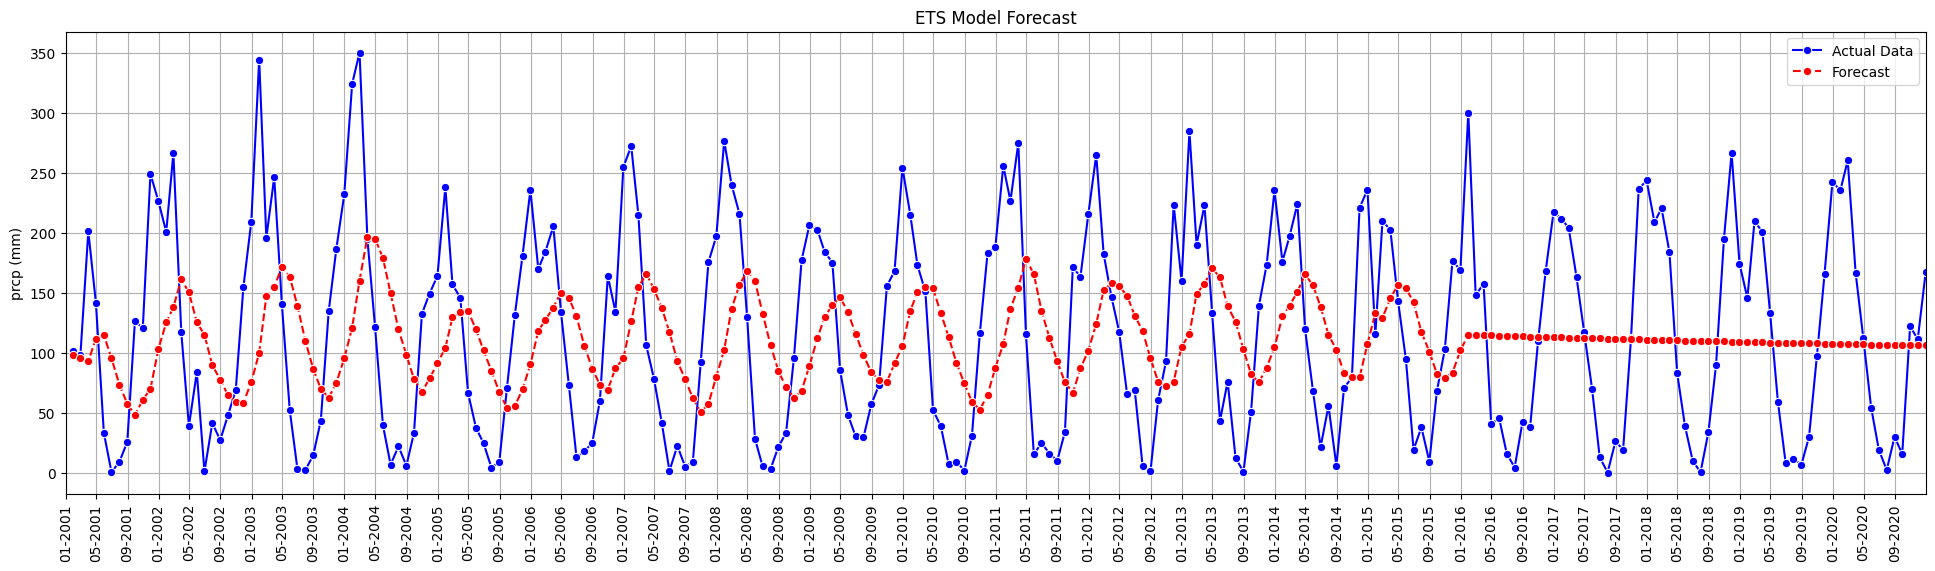

In [39]:
import matplotlib.dates as mdates

forecast = holt.forecast(steps=len(test))
fitted_values = pd.concat([holt.fittedvalues, forecast])
fitted_values.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')

plt.figure(figsize=(24, 6))
sns.lineplot(data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(fitted_values, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("ETS Model Forecast")
plt.legend()
# plt.savefig('../forecast/simple_ets_model.png')
plt.show()

## 3. Holt Winters:

Grid search:

In [40]:
import itertools
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import r2_score

trend_types = [None, "add", "mul"]
seasonal_types = [None, "add", "mul"]

hw_models = []
aics = []
r2s = []

for trend, seasonal in itertools.product(trend_types, seasonal_types):
    model = ExponentialSmoothing(train['prcp'], trend=trend, damped_trend=trend is not None, seasonal=seasonal, seasonal_periods=12).fit()
    hw_models.append(model)
    aics.append(model.aic)
    forecast = model.forecast(steps=len(test))
    r2s.append(r2_score(test['prcp'], forecast))

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Grid search results:

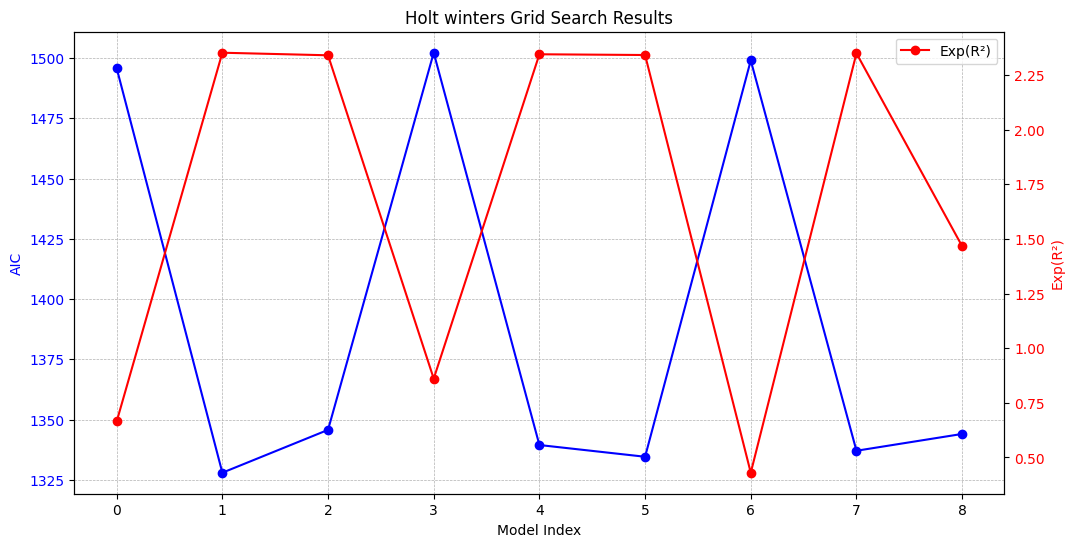

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Tạo figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Trục y thứ nhất (trái) - AIC
ax1.plot(aics, color="blue", marker="o", label="AIC")
ax1.set_xlabel("Model Index")
ax1.set_ylabel("AIC", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xticks(range(0, 19))
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Tạo trục y thứ hai (phải) - Exp(R²)
ax2 = ax1.twinx()
ax2.plot(np.exp(r2s), color="red", marker="o", label="Exp(R²)")
ax2.set_ylabel("Exp(R²)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Tiêu đề
plt.title("Holt winters Grid Search Results")
plt.legend()
# plt.savefig('holt_winters_grid_search.png')
plt.show()

As we can see, the 1st model yield best performance.

In [42]:
best_hw = hw_models[1]
best_hw.summary()

Dep. Variable:,prcp,No. Observations:,180
Model:,ExponentialSmoothing,SSE,246468.003
Optimized:,True,AIC,1327.966
Trend:,None,BIC,1372.667
Seasonal:,Additive,AICC,1331.303
Seasonal Periods:,12,Date:,"Thu, 06 Mar 2025"
Box-Cox:,False,Time:,10:12:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0033402,alpha,True
smoothing_seasonal,0.0610657,gamma,True


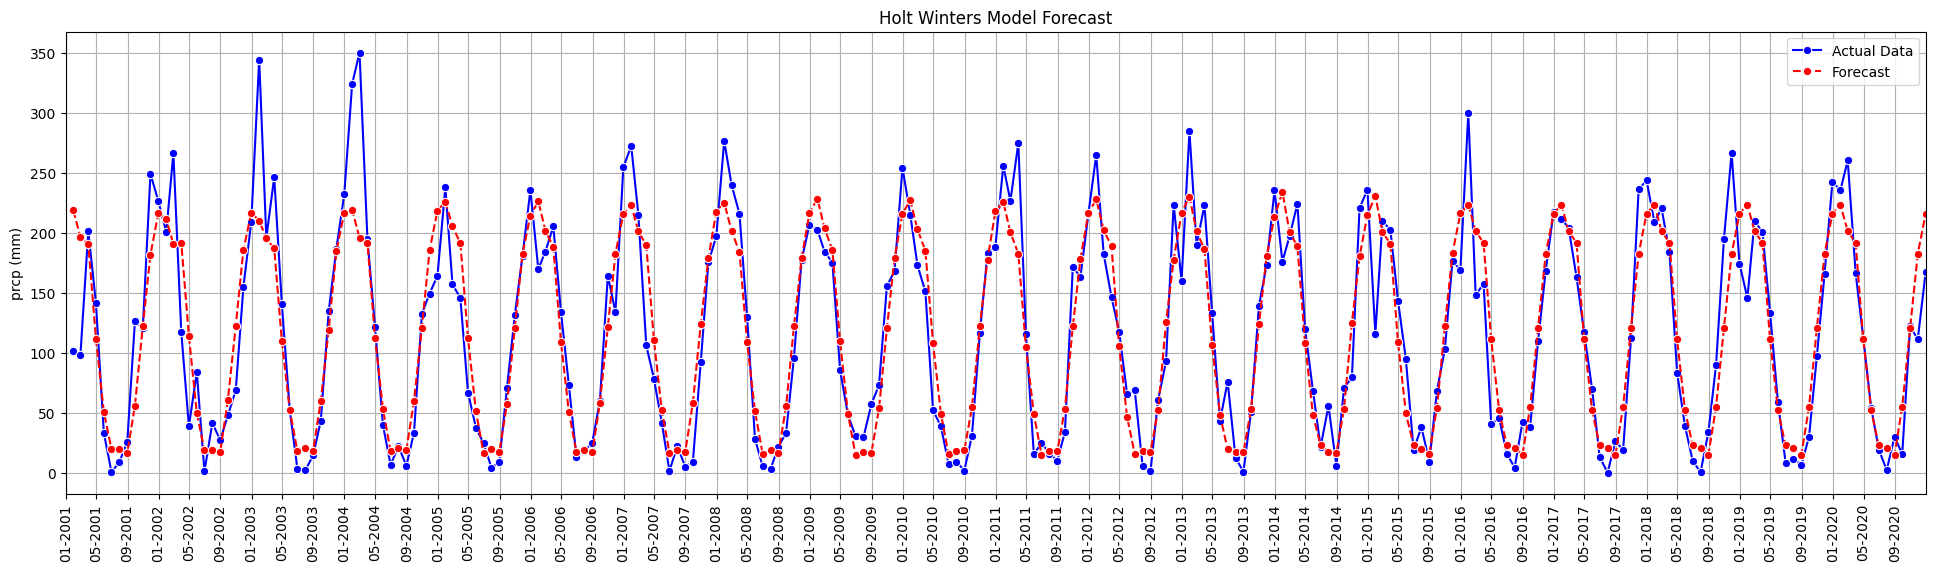

In [115]:
import seaborn as sns
import matplotlib.dates as mdates

forecast = best_hw.forecast(steps=len(test))
fitted_values = pd.concat([best_hw.fittedvalues, forecast])
fitted_values.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')

plt.figure(figsize=(24, 6))
sns.lineplot(data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(fitted_values, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Holt Winters Model Forecast")
plt.legend()
# plt.savefig('../forecast/holt_winters_model.png')
plt.show()

Evaluate:

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test['prcp'], forecast)
rmse = mse ** 0.5
mae = mean_absolute_error(test['prcp'], forecast)
r2 = r2_score(test['prcp'], forecast)
aic = best_hw.aic
bic = best_hw.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 1077.66
RMSE: 32.83
MAE: 24.71
R²: 0.855
AIC: 1327.97
BIC: 1372.67


## 4. ETS

##### Grid search:

In [3]:
import itertools
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import r2_score

error_types = ["add", "mul"]
trend_types = [None, "add", "mul"]
seasonal_types = [None, "add", "mul"]

models = []
aics = []
r2s = []

for error, trend, seasonal in itertools.product(error_types, trend_types, seasonal_types):
    model = ETSModel(
        train['prcp'], error=error, trend=trend, seasonal=seasonal, 
        seasonal_periods=12
    ).fit()
    models.append(model)
    aics.append(model.aic)
    forecast = model.forecast(steps=len(test))
    r2s.append(r2_score(test['prcp'], forecast))

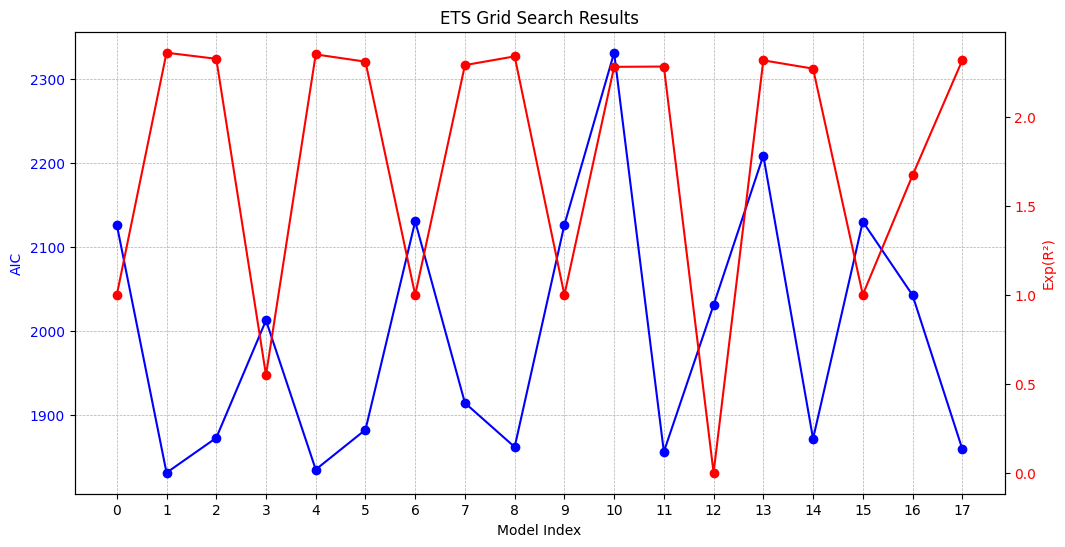

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Tạo figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Trục y thứ nhất (trái) - AIC
ax1.plot(aics, color="blue", marker="o", label="AIC")
ax1.set_xlabel("Model Index")
ax1.set_ylabel("AIC", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xticks(range(0, 19))
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)

# Tạo trục y thứ hai (phải) - Exp(R²)
ax2 = ax1.twinx()
ax2.plot(np.exp(r2s), color="red", marker="o", label="Exp(R²)")
ax2.set_ylabel("Exp(R²)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Tiêu đề
plt.title("ETS Grid Search Results")

plt.savefig('ets_grid_search.png')
plt.show()


- Due to the graph, we will choose 1st model

In [5]:
best_model = models[1]
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                   prcp   No. Observations:                  180
Model:                       ETS(ANA)   Log Likelihood                -899.475
Date:                Sun, 13 Apr 2025   AIC                           1830.950
Time:                        17:56:14   BIC                           1882.038
Sample:                    01-31-2001   HQIC                          1851.664
                         - 12-31-2015   Scale                         1282.147
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0001        nan        nan        nan         nan         nan
smoothing_seasonal   9.999e-05        nan        nan        nan         nan         nan
initial_level         229.3485        nan        nan        nan         nan         nan
initial_seasonal.0    -17.1434        nan        nan        nan         nan         nan
initial_seasonal.1    -48.3903        nan        nan        nan         nan         nan
initial_seasonal.2   -109.4462        nan        nan        nan         nan         nan
initial_seasonal.3   -175.1172        nan        nan        nan         nan         nan
initial_seasonal.4   -214.5174        nan        nan        nan         nan         nan
initial_seasonal.5   -209.9595        nan        nan        nan         nan         nan
initial_seasonal.6   -208.9188        nan        nan        nan         nan         nan
initial_seasonal.7   -178.3600        nan        nan        nan         nan         nan
initial_seasonal.8   -121.4369        nan        nan        nan         nan         nan
initial_seasonal.9    -40.7766        nan        nan        nan         nan         nan
initial_seasonal.10   -24.7575        nan        nan        nan         nan         nan
initial_seasonal.11          0        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       22.96   Jarque-Bera (JB):                51.91
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

- This is ETS(A,N,A) model (additive model)

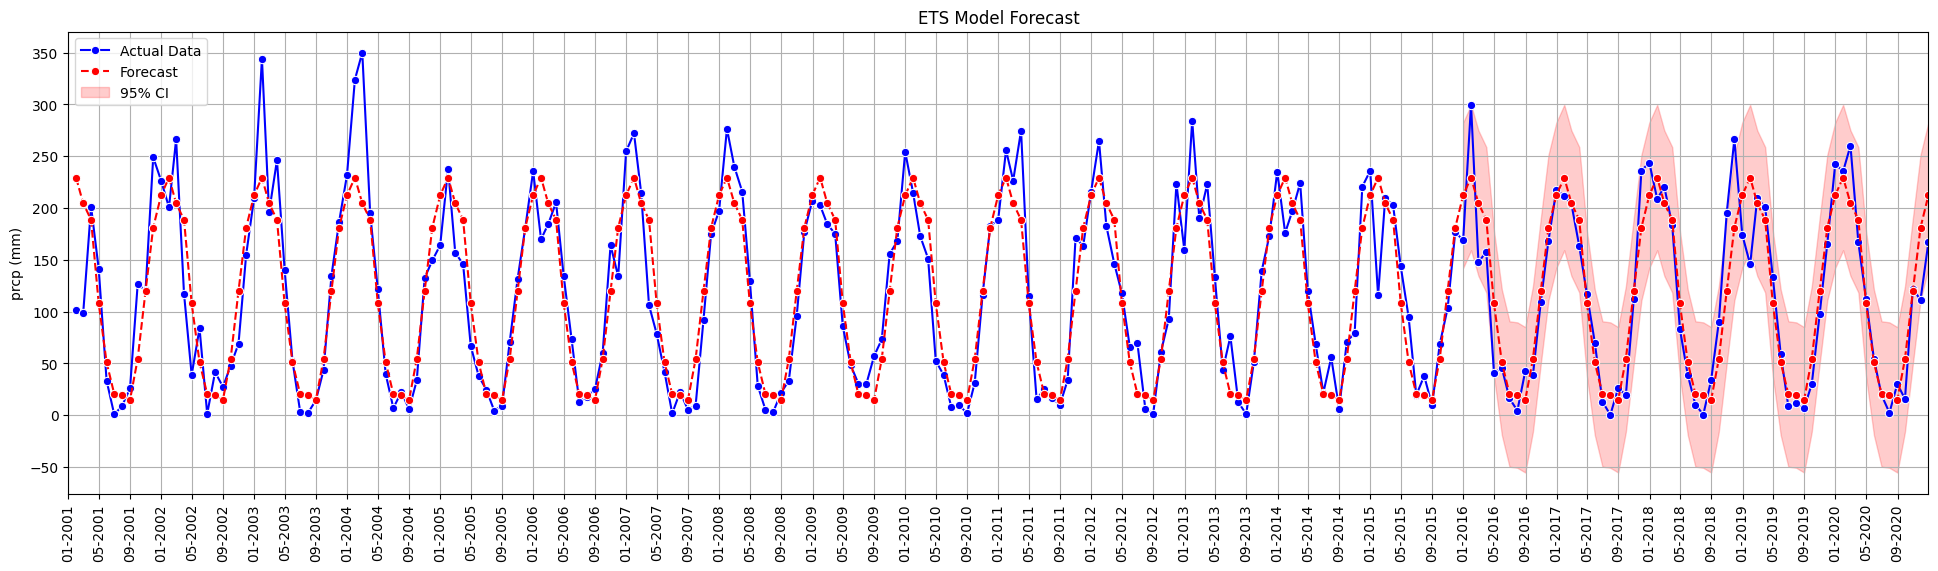

In [10]:
import seaborn as sns
import matplotlib.dates as mdates

prediction = best_model.get_prediction(start='2015-12-31', end='2020-12-31').summary_frame(alpha=0.05)

fitted_values = pd.concat([best_model.fittedvalues[:-1], prediction['mean']])
fitted_values.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')

plt.figure(figsize=(24, 6))
sns.lineplot(data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(fitted_values, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.fill_between(prediction.index, prediction.pi_lower, prediction.pi_upper, color="red", alpha=0.2, label="95% CI")
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("ETS Model Forecast")
plt.legend()
plt.savefig('../forecast/ets_ana_model.png')
plt.show()

Evaluate best model:

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

mse = mean_squared_error(test['prcp'], prediction['mean'][1:])
rmse = mse ** 0.5
mae = mean_absolute_error(test['prcp'], prediction['mean'][1:])
r2 = r2_score(test['prcp'], prediction['mean'][1:])
aic = best_model.aic
bic = best_model.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mean_absolute_percentage_error(test['prcp'], prediction['mean'][1:])}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 1057.33
RMSE: 32.52
MAE: 24.26
MAPE: 2.150462625826286
R²: 0.858
AIC: 1830.95
BIC: 1882.04
